In [Part I](http://www.datasciencebytes.com/bytes/2014/12/30/topic-modeling-of-shakespeare-characters/) of this post I made a topic model of the speech of Shakespeare characters from eight plays. Here in Part II I'll analyze the results of the model. [Download notebook](https://github.com/frankcleary/data-science-bytes/blob/master/content/shkspr-model-part-2.ipynb).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict
from gensim import corpora, models, similarities
from pprint import pprint

Here I load data from [Part I](http://www.datasciencebytes.com/bytes/2014/12/30/topic-modeling-of-shakespeare-characters/). [You can find the data here](https://github.com/frankcleary/data-science-bytes/tree/master/content/data).

In [2]:
word_data_df = pd.read_csv('data/word_data_df.csv', index_col=0)
personae = [tuple(character) for character in word_data_df[['persona', 'play']].values]
plays = word_data_df['play'].unique()
corpus = corpora.mmcorpus.MmCorpus('data/shkspr.mm')
tfidf = models.TfidfModel(corpus)
lsi = models.lsimodel.LsiModel.load('data/shkspr.lsi')

`gensim` can calculate a similarity value between each character, using a cosine similarity metric. The input is the model and the corpus of each character's speech.

In [3]:
matsim = similarities.MatrixSimilarity(lsi[tfidf[corpus]], num_best=6)

For each of the ten characters with the most lines, this prints the most similiar characters along with their similarity scores. Most characters are most similar to other characters in their play. Under this model Mark Antony in _Antony and Cleopatra_ is more closely related to three other characters from _Antony and Cleopatra_ than to himself in _Julius Ceasar_. This doesn't seem too far fetched, as characters in different plays are concerned with different people and problems.

In [4]:
for sims in list(matsim)[:10]:
    persona_index = sims[0][0]
    print '|'.join(personae[persona_index])
    for other_persona_index, score in sims[1:]:
        print '\t{:<30}{:.3f}'.format('|'.join(personae[other_persona_index]), score)

HAMLET|hamlet
	KING CLAUDIUS|hamlet          0.384
	LORD POLONIUS|hamlet          0.314
	MACBETH|macbeth               0.308
	OTHELLO|othello               0.297
	IAGO|othello                  0.291
IAGO|othello
	BIANCA|othello                0.502
	OTHELLO|othello               0.465
	DESDEMONA|othello             0.458
	LODOVICO|othello              0.425
	EMILIA|othello                0.424
OTHELLO|othello
	IAGO|othello                  0.465
	CASSIO|othello                0.397
	EMILIA|othello                0.369
	DESDEMONA|othello             0.339
	HAMLET|hamlet                 0.297
MARK ANTONY|a_and_c
	CLEOPATRA|a_and_c             0.367
	DOMITIUS ENOBARBUS|a_and_c    0.340
	OCTAVIUS CAESAR|a_and_c       0.316
	BRUTUS|j_caesar               0.273
	ANTONY|j_caesar               0.252
MACBETH|macbeth
	LADY MACBETH|macbeth          0.331
	HAMLET|hamlet                 0.308
	LENNOX|macbeth                0.272
	DUNCAN|macbeth                0.271
	MACDUFF|macbeth               0.

Latent Sementic Indexing (LSI) creates a lower dimensional subspace of the space spanned by all words (i.e. a space in which each word represents one orthogonal dimension). The speech of each character can be projected into this smaller dimensional space. Below is the projection of Hamlet's speech into the first 10 dimensions. Because of the way the space is constructed, the first dimensions contain the most information.

In [5]:
lsi[tfidf[corpus[0]]][:10]

[(0, 0.59246577031622616),
 (1, -0.14281562247124016),
 (2, 0.096597123493435619),
 (3, -0.041090063998733474),
 (4, 0.0054346234670322726),
 (5, -0.2281871246338642),
 (6, 0.0022814406628075051),
 (7, -0.114377333096131),
 (8, 0.096684501194655312),
 (9, -0.022321022902042544)]

The functions below plot the projection of each character's speech onto two of the axes (topics) defined by the LSI model. This is useful for visualizing the result of the model. The most important 10 words in each topic are printed above the graph.

In [6]:
def format_topic_coeffs(topic):
    """Return a list of coefficent, word tuples with coefficent truncated to 
    3 decimal places.
    """
    return [('{0:.3f}'.format(coeff), word) for coeff, word in topic]

def plot_axes(x=0, y=1, model=lsi, corpus=corpus, 
              tfidf=tfidf, personae=personae, plays=plays):
    """Plot each character in personae according to the projection of their
    speech into the given x and y topic axes of model.
    
    Points are colored according to play and labeled with the character.
    
    :param x: the index of the x axis to plot
    :param y: the index of the y axis to plot
    :param model: the gensim model to project into
    :param corpus: the gensim corpus of documents
    :param tfidf: a tfidf model for converting documents into tfidf space
    :param personae: a list of (character, play) tuples, the order must correspond to
      the order of documents in the corpus
    :param plays: a list of all the plays existing in the data
    """
    x_data = defaultdict(list)
    y_data = defaultdict(list)
    chars = defaultdict(list)
    print 'x topic:'
    pprint(format_topic_coeffs(model.show_topic(x)))
    print ''
    print 'y topic:'
    pprint(format_topic_coeffs(model.show_topic(y)))
    for persona, doc in zip(personae, corpus):
        play = persona[1]
        x_data[play].append((model[tfidf[doc]][x][1]))
        y_data[play].append((model[tfidf[doc]][y][1]))
        chars[play].append(persona[0])
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    cmap = plt.get_cmap('Paired')
    play_index = {play: i for i, play in enumerate(plays)}
    for play in play_index:
        color_index = play_index[play] / float(len(play_index))
        plt.scatter(x_data[play], y_data[play], color=cmap(color_index), 
                    label=play, alpha=.5, s=40)
        for char, x, y in zip(chars[play], x_data[play], y_data[play]):
            ax.annotate(char, xy=(x, y), xycoords='data', xytext=(1, 1), 
                        textcoords='offset points', size=10)
    plt.legend(loc=1, ncol=2, scatterpoints=1)

Here the y-axis separates the plays about Romans from other plays. Looking at the list of words that make up this topic, we can see that the Romans talk a lot about "Caesar", "Antony", and "Rome", but not much about "Romeo" or "Tybalt". The characters from _Romeo and Juliet_ are the opposite, and they extend the other way along the y-axis.

x topic:
[('0.192', u'caesar'),
 ('0.125', u'lord'),
 ('0.121', u'antony'),
 ('0.112', u'brutus'),
 ('0.106', u'thou'),
 ('0.105', u'romeo'),
 ('0.093', u'cassio'),
 ('0.091', u'love'),
 ('0.084', u'thee'),
 ('0.078', u'madam')]

y topic:
[('0.513', u'caesar'),
 ('0.378', u'brutus'),
 ('0.286', u'antony'),
 ('0.192', u'cassius'),
 ('-0.151', u'romeo'),
 ('0.139', u'rome'),
 ('-0.108', u'cassio'),
 ('0.090', u'octavius'),
 ('0.081', u'lepidus'),
 ('-0.073', u'tybalt')]


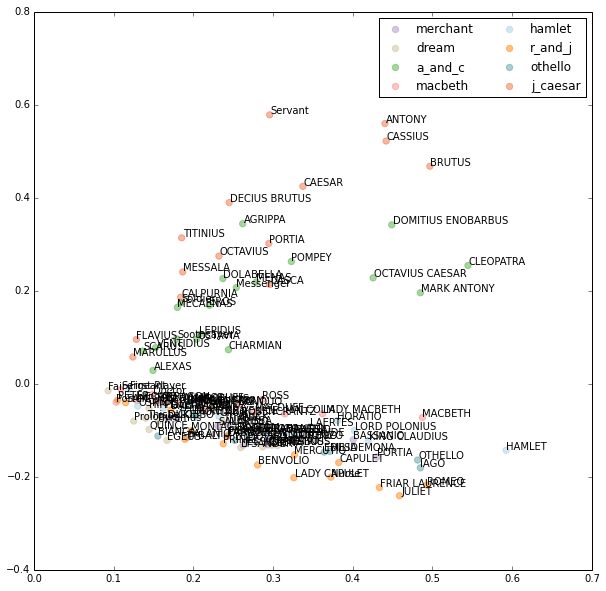

In [7]:
plot_axes(x=0, y=1)

The next two axes separate out several of the other plays. Characters from _Romeo and Juliet_, _Othello_, and _A Midsummer Night's Dream_ extending along the axes in different directions, while to a lesser extent the characters from _The Merchant of Venice_ have some projection on the y-axis.

x topic:
[('0.460', u'cassio'),
 ('-0.351', u'romeo'),
 ('-0.170', u'tybalt'),
 ('0.164', u'iago'),
 ('0.163', u'moor'),
 ('-0.125', u'juliet'),
 ('-0.115', u'nurse'),
 ('0.110', u'desdemona'),
 ('0.105', u'lord'),
 ('0.104', u'lieutenant')]

y topic:
[('0.367', u'romeo'),
 ('-0.253', u'hermia'),
 ('-0.244', u'demetrius'),
 ('-0.241', u'lysander'),
 ('0.215', u'cassio'),
 ('0.173', u'tybalt'),
 ('-0.157', u'pyramus'),
 ('-0.152', u'thisby'),
 ('-0.132', u'helena'),
 ('0.124', u'juliet')]


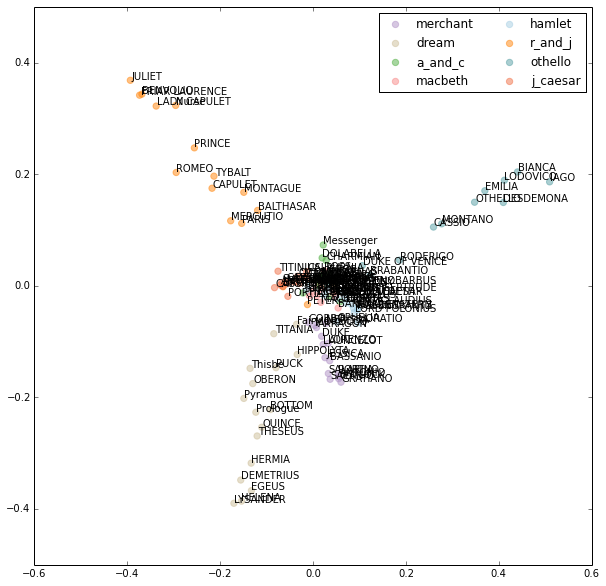

In [8]:
plot_axes(x=2, y=3)

In the next set of axes the characters from _The Merchant of Venice_ are well separated from those in the other plays along the x-axis, while characters from _Hamlet_ and _Macbeth_ extend along the y-axis. That these characters would be clustered is no surprise, above we can see that Hamlet and Macbeth (the people) both have places among each other's top 3 most similar characters.

x topic:
[('0.279', u'jew'),
 ('-0.245', u'cassio'),
 ('0.231', u'antonio'),
 ('0.215', u'launcelot'),
 ('0.198', u'bassanio'),
 ('-0.192', u'hermia'),
 ('-0.184', u'demetrius'),
 ('-0.181', u'lysander'),
 ('0.156', u'ducats'),
 ('0.150', u'lorenzo')]

y topic:
[('0.315', u'cassio'),
 ('-0.280', u'hamlet'),
 ('0.245', u'brutus'),
 ('-0.147', u'king'),
 ('-0.145', u'lord'),
 ('0.124', u'cassius'),
 ('0.114', u'hermia'),
 ('0.113', u'demetrius'),
 ('0.111', u'jew'),
 ('0.110', u'lysander')]


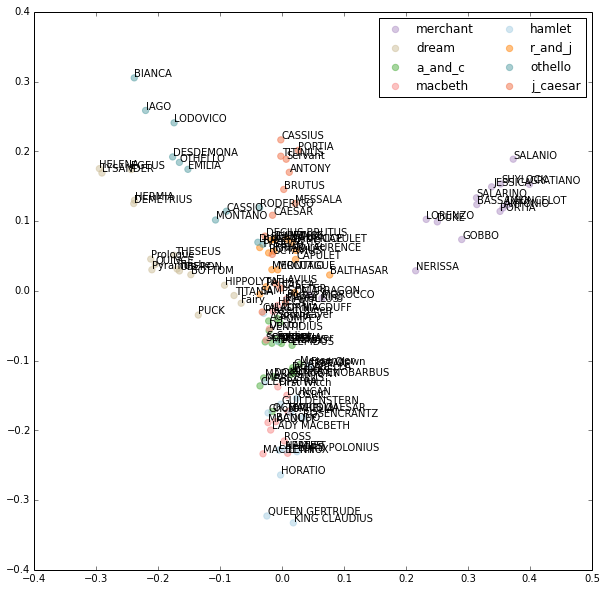

In [9]:
plot_axes(x=4, y=5)

Back to [Part I](http://www.datasciencebytes.com/bytes/2014/12/30/topic-modeling-of-shakespeare-characters/).